# Analyzing Crime Data

This R notebook delves into publicly available data to decipher crime patterns within a city. 

Through various data exploration and analysis tasks, including table intersections, aggregations, and visualizations, the goal is to understand the relationship between civilian-reported and police-reported incidents. The exploration aims to uncover key insights into crime trends within the city.


## Importing Libraries and Reading the Data

In [4]:
# Load required packages
library(tidyverse)
library(lubridate)

# Read datasets and assign to variables
incidents <- read_csv("incidents.csv")
calls <- read_csv("calls-for-service.csv")
print('Done!')

str(incidents)
str(calls)


Rows: 70897 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, Lo...
dbl  (4): IncidntNum, X, Y, PdId
dttm (1): Date
time (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Descript, Disposition, Address, City, State, Address Type, Common ...
dbl  (2): Crime Id, Agency Id
dttm (4): Report Date, Date, Offense Date, Call Date Time
time (1): Call Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Done!"
spc_tbl_ [70,897 × 13] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ IncidntNum: num [1:70897] 1.76e+08 1.61e+08 1.60e+08 1.60e+08 9.05e+07 ...
 $ Category  : chr [1:70897] "LARCENY/THEFT" "ASSAULT" "ROBBERY" "KIDNAPPING" ...
 $ Descript  : chr [1:70897] "GRAND THEFT FROM UNLOCKED AUTO" "BATTERY" "ROBBERY, BODILY FORCE" "KIDNAPPING, ADULT VICTIM" ...
 $ DayOfWeek : chr [1:70897] "Saturday" "Thursday" "Tuesday" "Friday" ...
 $ Date      : POSIXct[1:70897], format: "2017-05-13" "2016-07-14" ...
 $ Time      : 'hms' num [1:70897] 10:20:00 16:00:00 14:19:00 23:57:00 ...
  ..- attr(*, "units")= chr "secs"
 $ PdDistrict: chr [1:70897] "SOUTHERN" "MISSION" "NORTHERN" "SOUTHERN" ...
 $ Resolution: chr [1:70897] "NONE" "NONE" "ARREST, BOOKED" "ARREST, BOOKED" ...
 $ Address   : chr [1:70897] "800 Block of BRYANT ST" "MISSION ST / CESAR CHAVEZ ST" "700 Block of WEBSTER ST" "0 Block of 4TH ST" ...
 $ X         : num [1:70897] -122 -122 -122 -122 -122 ...
 $ Y         : num [1:70897] 37.8

## Exploring the Data

In [5]:
# Glimpse the structure of both datasets
glimpse(incidents)
glimpse(calls)

# Aggregate the number of reported incidents by date
daily_incidents <- incidents %>% 
    count(Date, sort = TRUE) %>% 
    rename(n_incidents = n)

# Aggregate the number of calls for police service by date
daily_calls <- calls %>% 
    count(Date, sort = TRUE) %>% 
    rename(n_calls = n)

Rows: 70,897
Columns: 13
$ IncidntNum <dbl> 176122807, 160569314, 160362475, 160435298, 90543656, 18001…
$ Category   <chr> "LARCENY/THEFT", "ASSAULT", "ROBBERY", "KIDNAPPING", "MISSI…
$ Descript   <chr> "GRAND THEFT FROM UNLOCKED AUTO", "BATTERY", "ROBBERY, BODI…
$ DayOfWeek  <chr> "Saturday", "Thursday", "Tuesday", "Friday", "Tuesday", "Su…
$ Date       <dttm> 2017-05-13, 2016-07-14, 2016-05-03, 2016-05-27, 2009-05-26…
$ Time       <time> 10:20:00, 16:00:00, 14:19:00, 23:57:00, 07:40:00, 18:00:00…
$ PdDistrict <chr> "SOUTHERN", "MISSION", "NORTHERN", "SOUTHERN", "TARAVAL", "…
$ Resolution <chr> "NONE", "NONE", "ARREST, BOOKED", "ARREST, BOOKED", "LOCATE…
$ Address    <chr> "800 Block of BRYANT ST", "MISSION ST / CESAR CHAVEZ ST", "…
$ X          <dbl> -122.4034, -122.4182, -122.4299, -122.4050, -122.4612, -122…
$ Y          <dbl> 37.77542, 37.74817, 37.77744, 37.78512, 37.71912, 37.80614,…
$ Location   <chr> "{'latitude': '37.775420706711', 'human_address': '{\"addre…
$ PdId       <d

## Merge the Datasets
To identify the relationship between civilian-reported incidents and police-reported incidents by the date on which the incidents were documented.

In [6]:
# Join data frames to create a new "mutated" set of information
shared_dates <- inner_join(daily_incidents, daily_calls, by = c("Date" = "Date"))

# Take a glimpse of this new data frame
glimpse(shared_dates)

Rows: 776
Columns: 3
$ Date        <dttm> 2017-03-17, 2017-06-25, 2017-03-01, 2017-09-01, 2016-04-0…
$ n_incidents <int> 105, 103, 101, 101, 100, 96, 95, 95, 95, 94, 94, 93, 93, 9…
$ n_calls     <int> 129, 120, 133, 138, 124, 127, 143, 115, 124, 106, 159, 118…


## Frequency Trends

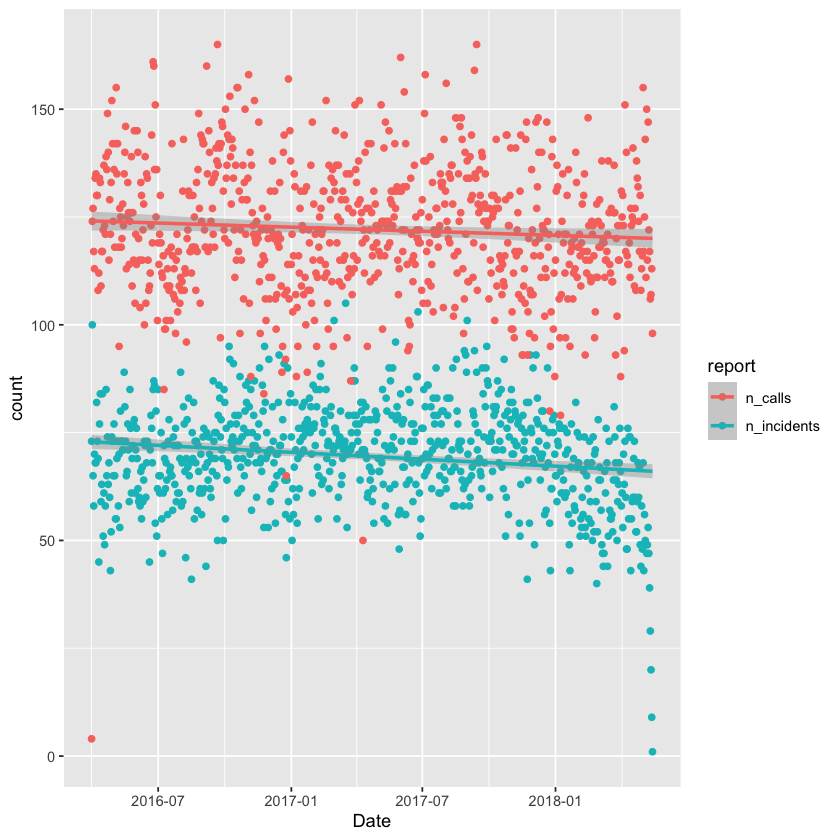

In [7]:
# Gather into long format using the "Date" column to define observations
plot_shared_dates <- shared_dates %>%
  gather(key = report, value = count, -Date)

# Plot points and regression trend lines
ggplot(plot_shared_dates, aes(x = Date, y = count, color = report)) +
  geom_point() +
  geom_smooth(method = "lm", formula = y ~ x)

## Correlation between Trends

In [8]:
# Calculate correlation coefficient between daily frequencies
daily_cor <- cor(shared_dates$n_incidents, shared_dates$n_calls)
daily_cor

# Summarize frequencies by month
correlation_df <- shared_dates %>% 
  mutate(month = month(Date)) %>%
  group_by(month) %>% 
  summarize(n_incidents = sum(n_incidents),
            n_calls = sum(n_calls))

# Calculate correlation coefficient between monthly frequencies
monthly_cor <- cor(correlation_df$n_incidents, correlation_df$n_calls)
monthly_cor

[1] 0.1350039

[1] 0.9608764

## Filtering Joins

In [9]:
# Filter calls to police by shared_dates
calls_shared_dates <- calls %>%
  semi_join(shared_dates, by = c("Date" = "Date"))

# Check the filtering join function 
identical(sort(unique(shared_dates$Date)), sort(unique(calls_shared_dates$Date)))

# Filter recorded incidents by shared_dates
incidents_shared_dates <- incidents %>% 
  semi_join(shared_dates, by = c("Date" = "Date"))

[1] TRUE

## Categorical Data Trends

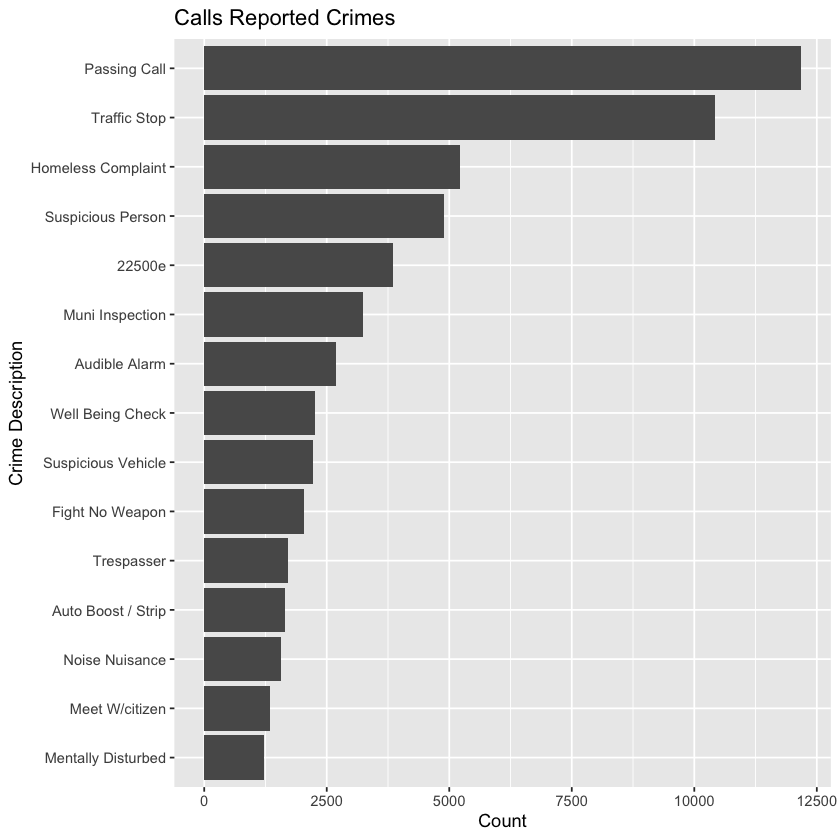

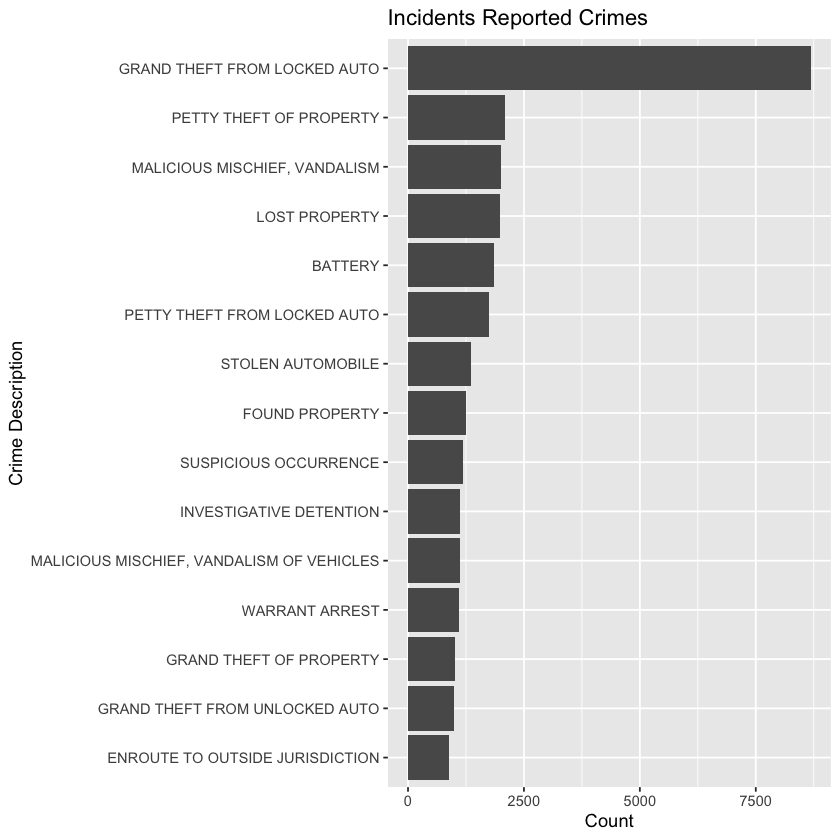

In [10]:
# Create a bar chart of the number of calls for each crime
plot_calls_freq <- calls_shared_dates %>% 
  count(Descript) %>% 
  top_n(15, n) %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Calls Reported Crimes") +
  coord_flip()
  
# Create a bar chart of the number of reported incidents for each crime
plot_incidents_freq <- incidents_shared_dates %>% 
  count(Descript) %>% 
  top_n(15, n)  %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Incidents Reported Crimes") +
  coord_flip()

# Output the plots
plot_calls_freq
plot_incidents_freq

## Most Frequent Crime Locations

In [11]:
# Arrange the top 10 locations of called in crimes in a new variable
location_calls <- calls_shared_dates %>%
  filter(Descript == "Auto Boost / Strip") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Arrange the top 10 locations of reported incidents in a new variable
location_incidents <- incidents_shared_dates %>%
  filter(Descript == "GRAND THEFT FROM LOCKED AUTO") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Output the top locations of each dataset for comparison
location_calls
location_incidents

Address,n
<chr>,<int>
1100 Block Of Point Lobos Av,21
3600 Block Of Lyon St,20
100 Block Of Christmas Tree Point Rd,18
1300 Block Of Webster St,12
500 Block Of 6th Av,12
800 Block Of Vallejo St,10
1000 Block Of Great Hy,9
100 Block Of Hagiwara Tea Garden Dr,7
1100 Block Of Fillmore St,7


Address,n
<chr>,<int>
800 Block of BRYANT ST,441
500 Block of JOHNFKENNEDY DR,89
1000 Block of POINTLOBOS AV,84
800 Block of MISSION ST,61
2600 Block of GEARY BL,38
3600 Block of LYON ST,36
1300 Block of WEBSTER ST,35
1100 Block of FILLMORE ST,34
22ND ST / ILLINOIS ST,33


#### Locations where auto crimes occur and are reported most frequently: on Point Lobos Avenue, Lyon Street, and Mission Street.